## **Update 1**

In [1]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import torch
import torch.nn
import torchvision
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from torchvision.transforms import ToPILImage
from IPython.display import HTML, display

In [6]:
# Creating a CustomDataset class which retrives the images and annotations.

class Custom_Dataset(Dataset):
    def __init__(self,path_of_image,path_of_maskedimage):
        super().__init__()
        images_path = Path(path_of_image)
        maskedimages_path = Path(path_of_maskedimage)
        self.images = [p for p in images_path.glob('*.jpg')]
        self.maskedimages = [p for p in maskedimages_path.glob('*.png')]
        self.transform1 = torchvision.transforms.Compose([torchvision.transforms.Resize((1080,1080)),
                                                         torchvision.transforms.Normalize((0.0,0.0,0.0),(255.,255.,255.))])
        self.transform2 = torchvision.transforms.Compose([torchvision.transforms.Resize((1080,1080)),
                                                         torchvision.transforms.Normalize((0.0),(255.))])
        
    def __len__(self):
        length = len(self.images)
        return length
    
    def __getitem__(self,index):
        img = torchvision.io.read_image(str(self.images[index]))
        masked_img = torchvision.io.read_image(str(self.maskedimages[index]))
        img = torch.tensor(img,dtype=torch.float)
        masked_img = torch.tensor(masked_img,dtype=torch.float)
        img = self.transform1(img)
        masked_img = self.transform2(masked_img)
        return img,masked_img

In [7]:
# Creating a tuple of Training, Validation and Testing Datasets.
d = (Custom_Dataset('/kaggle/input/dl-update1/Dataset_train_val_test/Images/train','/kaggle/input/dl-update1/Dataset_train_val_test/annotations/train'),Custom_Dataset('/kaggle/input/dl-update1/Dataset_train_val_test/Images/val','/kaggle/input/dl-update1/Dataset_train_val_test/annotations/val'),Custom_Dataset('/kaggle/input/dl-update1/Dataset_train_val_test/Images/test','/kaggle/input/dl-update1/Dataset_train_val_test/annotations/test'))

In [8]:
def print_with_font_size(text, font_size=5):
    display(HTML(f"<font size='{font_size}'>{text}</font>"))

In [ ]:
for i in range(0,3):
    dataset = d[i]
    train_dataloader = torch.utils.data.DataLoader(dataset,batch_size=8)
    if i == 0 :
        print_with_font_size("Images and Annotated Images of Training Images : ", font_size=6)
    elif i == 1 :
        print_with_font_size("Images and Annotated Images of Validation Images : ", font_size=6)
    else :
        print_with_font_size("Images and Annotated Images of Testing Images : ", font_size=6)
    for batch in train_dataloader:
        imgs,masked_imgs = batch
        img_np = imgs[0].permute([1,2,0]).numpy()
        maskedimage_np = masked_imgs[0].permute([1,2,0]).numpy()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(img_np)
        ax2.imshow(maskedimage_np)
        plt.show()

## **Update 2**

# Import Libraries

In [10]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import cv2
import albumentations as A
import time
import os
from tqdm.notebook import tqdm


!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [14]:
IMAGE_PATH = '/kaggle/input/dl-dataset/image/'
MASK_PATH = '/kaggle/input/dl-dataset/labels/'

In [15]:
n_classes = 5 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  130


In [16]:
# data Split to Train, Validation and test
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.11, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  104
Val Size     :  13
Test Size    :  13


Image Size (4032, 3024, 3)
Mask Size (4032, 3024)


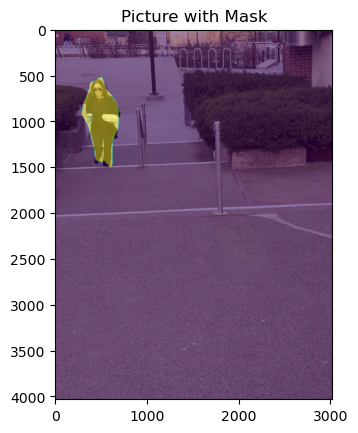

In [18]:
img = Image.open(IMAGE_PATH + df['id'][79] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][79] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.5)
plt.title('Picture with Mask')
plt.show()

# Dataset

In [19]:
class CustomDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [20]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5))])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5))])

#datasets
train_set = CustomDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train)
val_set = CustomDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val)

#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [21]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=5, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [22]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# Training

In [23]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [24]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
                    
                    
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [26]:
max_lr = 1e-3
epoch = 16
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 6.582 
Epoch:1/16.. Train Loss: 2.739.. Val Loss: 6.582.. Train mIoU:0.023.. Val mIoU: 0.019.. Train Acc:0.047.. Val Acc:0.045.. Time: 0.59m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 6.582 >> 2.614 
Epoch:2/16.. Train Loss: 1.994.. Val Loss: 2.614.. Train mIoU:0.048.. Val mIoU: 0.093.. Train Acc:0.112.. Val Acc:0.241.. Time: 0.50m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 2.614 >> 1.831 
Epoch:3/16.. Train Loss: 1.510.. Val Loss: 1.831.. Train mIoU:0.253.. Val mIoU: 0.212.. Train Acc:0.505.. Val Acc:0.568.. Time: 0.50m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.831 >> 0.974 
saving model...
Epoch:4/16.. Train Loss: 1.169.. Val Loss: 0.974.. Train mIoU:0.312.. Val mIoU: 0.313.. Train Acc:0.723.. Val Acc:0.797.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/16.. Train Loss: 0.891.. Val Loss: 1.206.. Train mIoU:0.361.. Val mIoU: 0.313.. Train Acc:0.803.. Val Acc:0.797.. Time: 0.50m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.206 >> 0.738 
Epoch:6/16.. Train Loss: 0.726.. Val Loss: 0.738.. Train mIoU:0.362.. Val mIoU: 0.390.. Train Acc:0.819.. Val Acc:0.840.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.738 >> 0.518 
Epoch:7/16.. Train Loss: 0.598.. Val Loss: 0.518.. Train mIoU:0.362.. Val mIoU: 0.332.. Train Acc:0.825.. Val Acc:0.861.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.518 >> 0.482 
Epoch:8/16.. Train Loss: 0.533.. Val Loss: 0.482.. Train mIoU:0.393.. Val mIoU: 0.367.. Train Acc:0.837.. Val Acc:0.879.. Time: 0.48m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.482 >> 0.458 
Epoch:9/16.. Train Loss: 0.504.. Val Loss: 0.458.. Train mIoU:0.376.. Val mIoU: 0.337.. Train Acc:0.845.. Val Acc:0.868.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:10/16.. Train Loss: 0.439.. Val Loss: 0.468.. Train mIoU:0.413.. Val mIoU: 0.343.. Train Acc:0.860.. Val Acc:0.867.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/16.. Train Loss: 0.421.. Val Loss: 0.472.. Train mIoU:0.420.. Val mIoU: 0.344.. Train Acc:0.854.. Val Acc:0.856.. Time: 0.48m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.472 >> 0.434 
saving model...
Epoch:12/16.. Train Loss: 0.404.. Val Loss: 0.434.. Train mIoU:0.401.. Val mIoU: 0.364.. Train Acc:0.861.. Val Acc:0.876.. Time: 0.51m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.434 >> 0.388 
Epoch:13/16.. Train Loss: 0.382.. Val Loss: 0.388.. Train mIoU:0.438.. Val mIoU: 0.364.. Train Acc:0.866.. Val Acc:0.885.. Time: 0.48m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/16.. Train Loss: 0.359.. Val Loss: 0.416.. Train mIoU:0.434.. Val mIoU: 0.365.. Train Acc:0.879.. Val Acc:0.877.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 0.416 >> 0.349 
Epoch:15/16.. Train Loss: 0.360.. Val Loss: 0.349.. Train mIoU:0.464.. Val mIoU: 0.379.. Train Acc:0.878.. Val Acc:0.896.. Time: 0.49m


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:16/16.. Train Loss: 0.377.. Val Loss: 0.389.. Train mIoU:0.421.. Val mIoU: 0.375.. Train Acc:0.873.. Val Acc:0.886.. Time: 0.50m
Total time: 7.97 m


In [27]:
torch.save(model, 'model.pt')

In [28]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

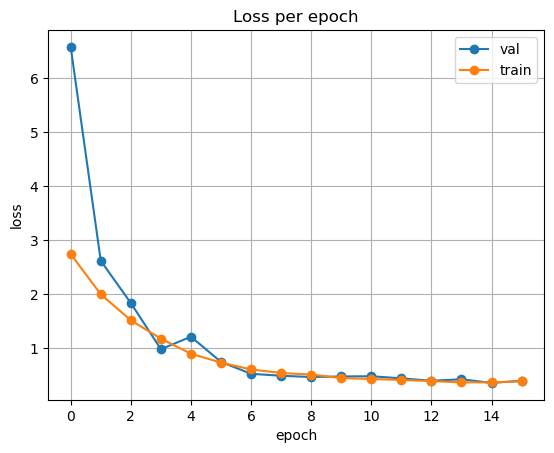

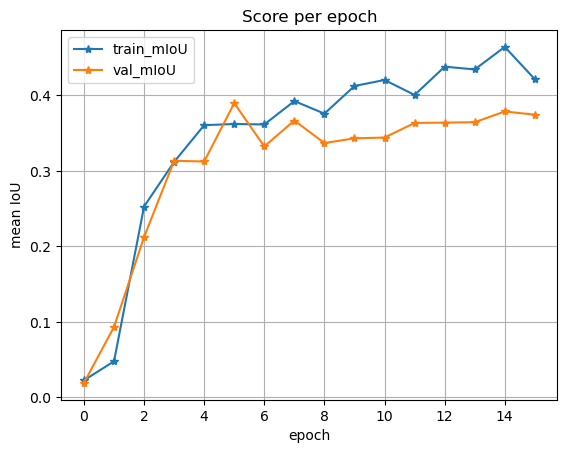

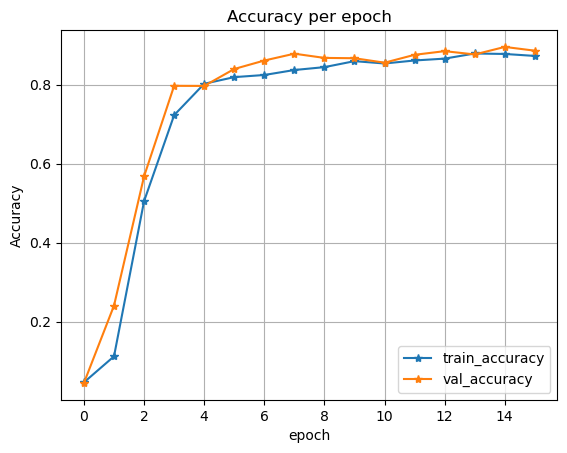

In [29]:
plot_loss(history)
plot_score(history)
plot_acc(history)

# Evaluation

In [30]:
class CustomTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = CustomTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [31]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [32]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [33]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [34]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [35]:
Mean_IoU = miou_score(model, test_set)

  0%|          | 0/13 [00:00<?, ?it/s]

In [37]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [38]:
pixel_accuracy = pixel_acc(model, test_set)

  0%|          | 0/13 [00:00<?, ?it/s]

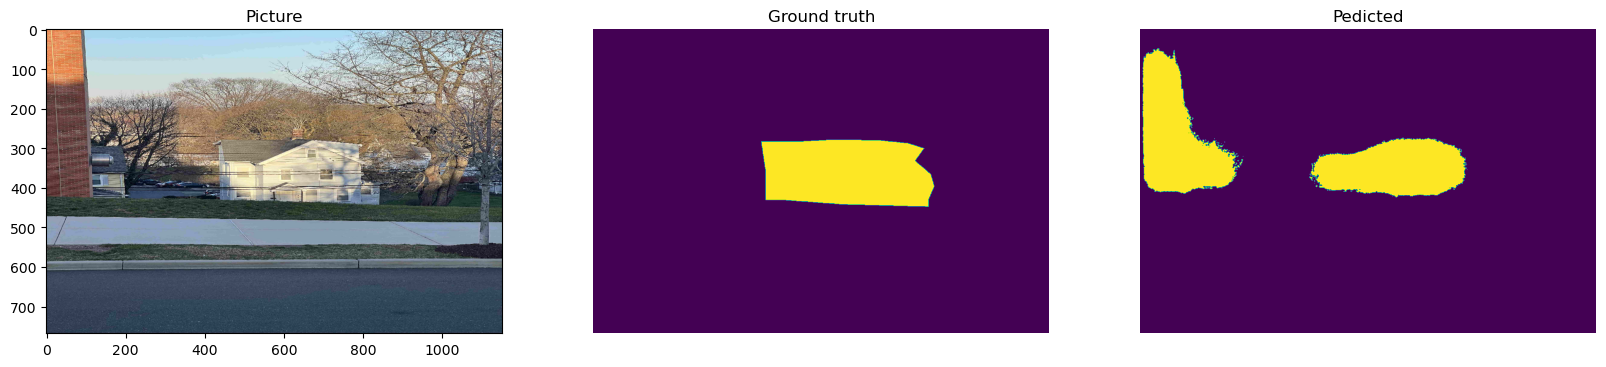

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('Pedicted')
ax3.set_axis_off()

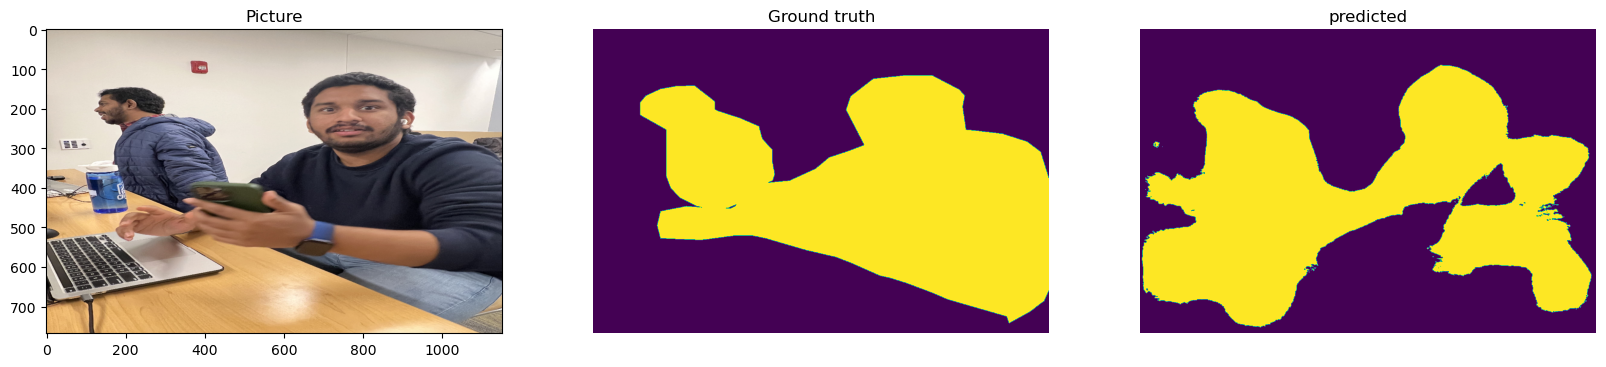

In [40]:
image2, mask2 = test_set[8]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('predicted')
ax3.set_axis_off()

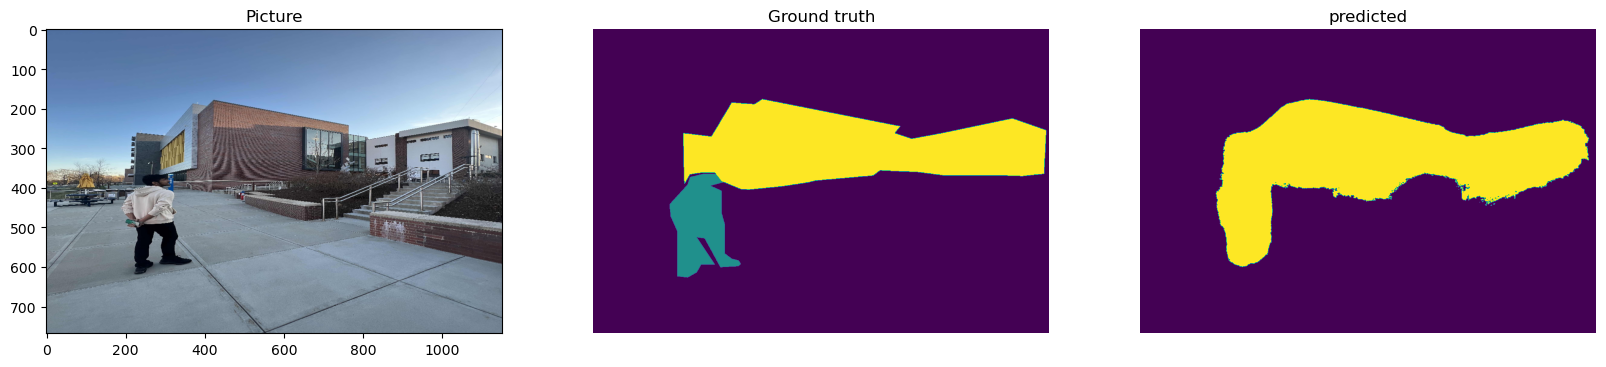

In [41]:
image3, mask3 = test_set[11]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('predicted')
ax3.set_axis_off()

In [42]:
print('Test Data mIoU', np.mean(Mean_IoU))

Test Data mIoU 0.6181245640293062


In [43]:
print('Test data pixel Accuracy', np.mean(pixel_accuracy))

Test data pixel Accuracy 0.8790450136885684
